In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.model_selection
import sklearn.preprocessing
import scipy.integrate
import sklearn.discriminant_analysis
import sklearn.ensemble
import sklearn.tree
import itertools
import sklearn.tree
import sklearn.metrics
import scipy
from pandas.tools.plotting import scatter_matrix

%matplotlib inline

Utilice el data set `OJ` para encontrar cual de los siguientes modelos logra predecir mejor el target `Purchase`:
  - Logistic regresion.
  - Linear discriminant analysis.
  - Classification Tree.
  - Random Forest. 
  Haga explicito el criterio que utiliza para comparar los modelos.


In [3]:
# Carga datos
data = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/OJ.csv')
data = data.drop(['Store7', 'PctDiscCH','PctDiscMM'],axis=1)

purchasebin = np.ones(len(data), dtype=int)
ii = np.array(data['Purchase']=='MM')
purchasebin[ii] = 0

data['Target'] = purchasebin
data = data.drop(['Purchase'],axis=1)

predictors = list(data.keys())
print(predictors)
predictors.remove('Target')
predictors.remove('Unnamed: 0')


['Unnamed: 0', 'WeekofPurchase', 'StoreID', 'PriceCH', 'PriceMM', 'DiscCH', 'DiscMM', 'SpecialCH', 'SpecialMM', 'LoyalCH', 'SalePriceMM', 'SalePriceCH', 'PriceDiff', 'ListPriceDiff', 'STORE', 'Target']


/home/nicomn97/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


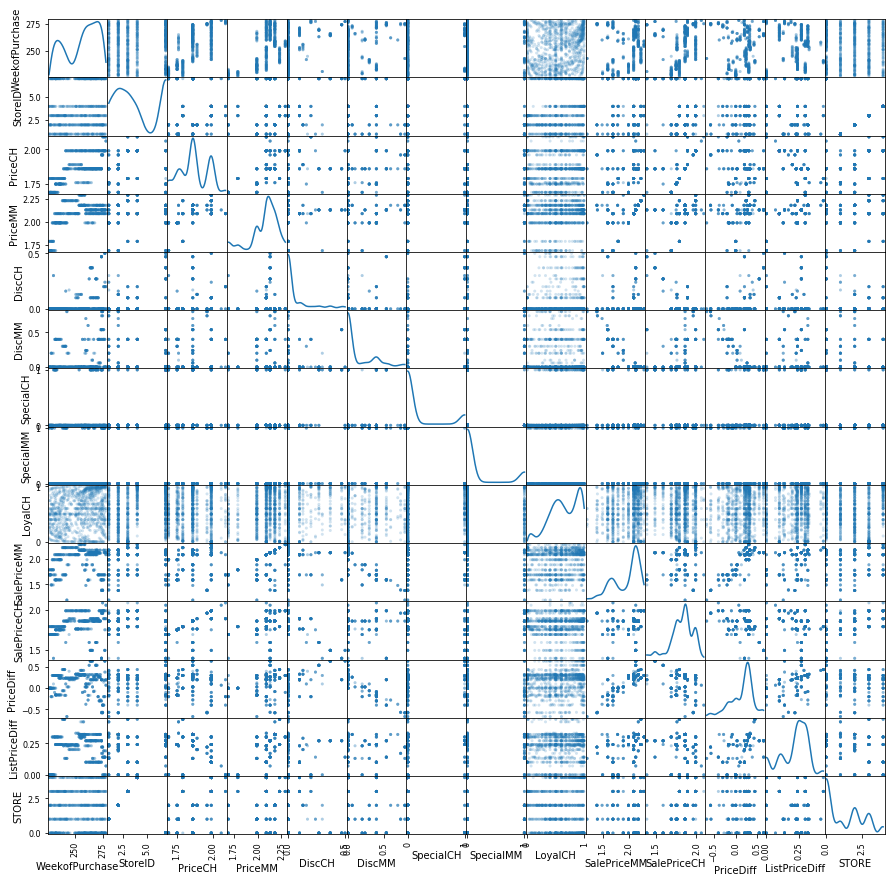

In [4]:
_ = scatter_matrix(data[predictors], alpha=0.2, figsize=(15, 15), diagonal='kde')

In [5]:
# Divide al comienzo train y test. Test solamente lo utilizare al final de todo.
# train lo divido mas abajo en train+validation
train_data, test_data = sklearn.model_selection.train_test_split(data, train_size=0.7)
modelos = {}

/home/nicomn97/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Logistic Regression

In [6]:
model_lr = sklearn.linear_model.LogisticRegression()
model_lr.fit(train_data[predictors], train_data.Target)
modelos['LR'] = model_lr

/home/nicomn97/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Linear Discriminant Analysis

In [7]:
model_lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
model_lda.fit(train_data[predictors], train_data.Target)
modelos['LDA'] = model_lda

/home/nicomn97/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


# Classification Tree

Para este metodo tengo que elegir el mejor valor de `max_depth`. Para eso voy a usar k-Fold cross validation

In [8]:
pr_area = 1.0
best_pr_area = 0.0
max_depth = 1

while max_depth<6 and (pr_area>=best_pr_area):
    n_splits = 6
    kfold = sklearn.model_selection.KFold(n_splits=n_splits)
    areas = np.zeros(n_splits)
    model_tree = sklearn.tree.DecisionTreeClassifier(max_depth=max_depth)
    i = 0 
    for train_index, test_index in kfold.split(train_data):
        model_tree.fit(train_data[predictors].iloc[train_index], train_data.Target.iloc[train_index])
        probas = model_tree.predict_proba(train_data[predictors].iloc[test_index])
    #print(model_tree.classes_, test_index)
        precision, recall, _ = sklearn.metrics.precision_recall_curve(train_data.Target.iloc[test_index], probas[:,1])
        ii = np.argsort(recall)
        areas[i] = scipy.integrate.trapz(precision[ii], recall[ii])
        i+=1
        
    pr_area = areas.mean()
    print(max_depth, pr_area, best_pr_area)
    if pr_area > best_pr_area:
        best_pr_area = pr_area
        max_depth += 1
    
    
print(max_depth)
modelos['TREE'] = model_tree

1 0.8738808787360576 0.0
2 0.8919787421198366 0.8738808787360576
3 0.910491666999782 0.8919787421198366
4 0.8940874193833306 0.910491666999782
4


# Random Forest

Para este metodo tengo que buscar un buen valor `n_estimators`. Para eso voy a usar k-Fold cross validation

In [9]:
pr_area = 1.0
best_pr_area = 0.0
n_estimators = 100

while n_estimators<200 and (pr_area>=best_pr_area):
    n_splits = 6
    kfold = sklearn.model_selection.KFold(n_splits=n_splits)
    areas = np.zeros(n_splits)
    model_forest = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators)
    i = 0 
    for train_index, test_index in kfold.split(train_data):
        model_forest.fit(train_data[predictors].iloc[train_index], train_data.Target.iloc[train_index])
        probas = model_forest.predict_proba(train_data[predictors].iloc[test_index])
        precision, recall, _ = sklearn.metrics.precision_recall_curve(train_data.Target.iloc[test_index], probas[:,1])
        ii = np.argsort(recall)
        areas[i] = scipy.integrate.trapz(precision[ii], recall[ii])
        i+=1
        
    pr_area = areas.mean()
    print(n_estimators, pr_area, best_pr_area)
    if pr_area > best_pr_area:
        best_pr_area = pr_area
        n_estimators += 1
    
    
print(n_estimators)
modelos['FOREST'] = model_forest

100 0.8977691735324362 0.0
101 0.9026930707603703 0.8977691735324362
102 0.893560609647749 0.9026930707603703
102


Text(0, 0.5, 'Precision')

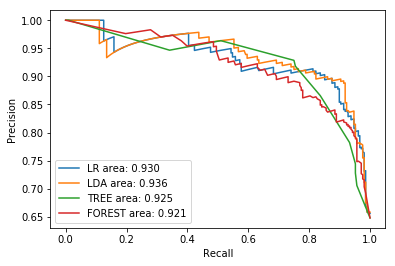

In [10]:
for k in modelos.keys():
    probas = modelos[k].predict_proba(test_data[predictors])
    precision, recall, _ = sklearn.metrics.precision_recall_curve(test_data.Target, probas[:,1])
    ii = np.argsort(recall)
    area = scipy.integrate.trapz(precision[ii], recall[ii])
    plt.plot(recall, precision, label=k+' area: {:.3f}'.format(area))
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')


El mejor modelo es **LDA**, pues tiene la mayor area bajo la curva de precission recall.